In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.optimize import fsolve, curve_fit, leastsq
from scipy.signal import savgol_filter
from scipy.stats import linregress

import os
import re

In [80]:
WD = '/Users/dbikiel/Dropbox/Compartidas/Compartida Dami - Seba/Obtencion Cte NO-tiol/Trazas H2S-NO/'
experiments = {}
for f in os.listdir(WD):
    name = re.split('_|.txt', f)[0:4]
    name[1] = re.split('uM', name[1])[0]
    name[3] = re.split('uM', name[3])
    name[1] = float(name[1])
    if name[3][1] == '':
        del name[3][1]
        name.append('A')
    elif name[3][1] == 'b':
        del name[3][1]
        name.append('B')
    name[3] = name[3][0].replace('(','.')
    name[3] = float(name[3].replace(')',''))

    if name[0] == 'NO':
        exp = (name[1], name[3], name[4])
    else:
        exp = (name[3], name[1], name[4])
        
    df = pd.read_csv( WD + f, header = None, sep = '\t')
    df.columns = ['time','HNO']
    
    df.time = pd.to_timedelta(df.time, unit = 'minutes')
    df = df.set_index('time')
    df.HNO = df.HNO*1e-6
    
    experiments[exp] = df

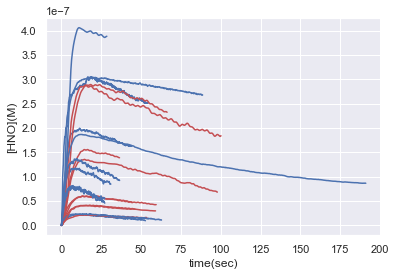

In [82]:
for i in experiments.keys():
    if i[0] == 2.0:
        plt.plot(experiments[i].index.total_seconds(),experiments[i].HNO, 'b')
    else:
        plt.plot(experiments[i].index.total_seconds(),experiments[i].HNO, 'r')
#plt.xlim([0.0, 25.0])
plt.ylabel('[HNO](M)')
plt.xlabel('time(sec)')
plt.show()

Defino las reacciones a simular (k estimadas):
    
$k_1 = 3.7x10^{7} M^{-1} s^{-1} \hspace{1cm} 2 NO \rightarrow (NO)_2$

$k_2 = 1.0x10^{10} s^{-1} \hspace{1cm} (NO)_2 \rightarrow 2 NO$

$k_3 = 1.0x10^{6} M^{-1} s^{-1} \hspace{1cm} (NO)_2 + H_2S \rightarrow HSNO + HNO$

$k_4 = 1.0x10^{3} M^{-1} s^{-1} \hspace{1cm} NO + H_2S \rightarrow H_2SNO$

$k_5 = 1.0x10^{3} M^{-1} s^{-1} \hspace{1cm} H_2SNO + NO \rightarrow HSNO + HNO$

$k_6 = 1.0x10^{3} M^{-1} s^{-1} \hspace{1cm} HSNO + H_2S \rightarrow HSSH + HNO$

$k_7 = 5.6x10^{6} M^{-1} s^{-1} \hspace{1cm} NO + HNO \rightarrow HN_2O_2$

$k_8 = 8x10^{6} M^{-1} s^{-1} \hspace{1cm} 2 HNO \rightarrow N_2O$

In [83]:
reactions = [
    # (coeff, r_stoich, net_stoich)
    ('k1', {'[NO]': 2}, {'[NO]': -2, '[N2O2]': 1}),
    ('k2', {'[N2O2]': 1}, {'[NO]': 2, '[N2O2]': -1}),
    ('k3', {'[N2O2]': 1, '[H2S]': 1}, {'[N2O2]': -1, '[H2S]': -1, '[HSNO]': 1, '[HNO]': 1}),
    ('k4', {'[NO]': 1, '[H2S]': 1}, {'[NO]': -1, '[H2S]': -1, '[H2SNO]': 1}),
    ('k5', {'[NO]': 1, '[H2SNO]': 1}, {'[NO]': -1, '[H2SNO]': -1, '[HSNO]': 1, '[HNO]': 1}),
    ('k6', {'[H2SNO]': 1, '[H2S]': 1}, {'[H2SNO]': -1, '[H2S]': -1, '[HSSH]': 1, '[HNO]': 1}),
    ('k7', {'[NO]': 1, '[HNO]': 1}, {'[NO]': -1, '[HNO]': -1, '[HN2O2]': 1}),
    ('k8', {'[HNO]': 2}, {'[HNO]': -2, '[N2O]': 1})
]
names = '[NO] [H2S] [N2O2] [HSNO] [HNO] [HSSH] [H2SNO] [HN2O2] [N2O]'.split()

In [84]:
from operator import mul
from functools import reduce
import sympy as sym

def prod(seq):
    return reduce(mul, seq) if seq else 1

def mk_exprs_symbs(rxns, names):
    # create symbols for reactants
    symbs = sym.symbols(names, real=True, nonnegative=True)
    # map between reactant symbols and keys in r_stoich, net_stoich
    c = dict(zip(names, symbs))
    f = {n: 0 for n in names}
    k = []
    for coeff, r_stoich, net_stoich in rxns:
        k.append(sym.S(coeff))
        r = k[-1]*prod([c[rk]**p for rk, p in r_stoich.items()])
        for net_key, net_mult in net_stoich.items():
            f[net_key] += net_mult*r
    return [f[n] for n in names], symbs, tuple(k)

In [163]:
def replace_fix_and_free(func, fixed_list):
    to_replace = [(ki, fixed_list[ki]) for ki in fixed_list.keys()]
    for i in range(len(func)):
        func[i] = func[i].subs(to_replace)
    return func

#Construyo el sistema de ecuaciones
ydot, y, k = mk_exprs_symbs(reactions, names)

#Reemplazo las constantes que considero fijas:
fixed_list = {'k1':0, 'k2':0, 'k3':0, 'k7': 5.6e6, 'k8': 8e6} # En M-1 s-1
ydot = replace_fix_and_free(ydot, fixed_list)

#Creo la funcion a evaluar, removiendo las constantes que son fijas
k_free = tuple([ki for ki in k if ki not in [sym.Symbol(kj) for kj in fixed_list.keys()]])

t = sym.symbols('t')
f = sym.lambdify((y, t) + k_free, ydot, 'numpy')

#Calculo el jacobiano
J = sym.Matrix(ydot).jacobian(y)
J_cb = sym.lambdify((y, t) + k_free, J, 'numpy') 

#Construyo la función
def hno_t(tspan, kvals, y0):
    k_vals = tuple([i for i in kvals])
#    yout = odeint(f, y0, tspan, k_vals, Dfun=J_cb)
    yout = odeint(f, y0, tspan, k_vals, atol = 1e-16, rtol = 1e-16, Dfun=J_cb)
    return yout[:,4]

In [164]:
y

[[NO], [H2S], [N2O2], [HSNO], [HNO], [HSSH], [H2SNO], [HN2O2], [N2O]]

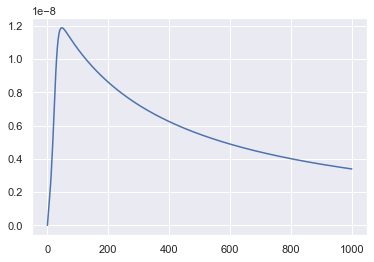

In [165]:
tspan = np.linspace(0, 1000,401)
y0 = np.array([1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])*1e-6

kvals = (
         100000,    #k4
         3000, #k5
         3000, #k6
         )

plt.plot(tspan, hno_t(tspan, kvals, y0))
plt.show()

In [231]:
def leastsq_func(params, *args):
    n_points_per_experiment = args[0]
    x_data = args[1]
    y_data = args[2]
    conc_per_experiment = args[3]
    
    factor = params[0]
    k_vals = [10**i for i in params[1:]]
    
    yfit = np.empty(y_data.shape)
    
    left = 0
    for i, val in enumerate(n_points_per_experiment):
        right = left + val
        yfit[left:right] = hno_t(x_data[left:right], k_vals, conc_per_experiment[i])
        left = right
    #return (y_data - yfit)/(y_data + 1.0e-8)
    #return (y_data - np.mean(y_data))/(np.std(y_data)) - (yfit - np.mean(yfit))/np.std(yfit)
    return factor*y_data - yfit

In [232]:
def build_multiple_experiments(experiments, remove_list, ini_point, fin_point):
    list_of_experiments = set(experiments.keys())
    usable_experiments = list_of_experiments - set(remove_list)
    usable_experiments = sorted(list(usable_experiments))
    
    x_data = []
    y_data = []
    n_points = []
    step = 1
    for exp in usable_experiments:
        x_data.extend(experiments[exp].HNO[ini_point:fin_point:step].index.total_seconds().values)
        y_data.extend(experiments[exp].HNO[ini_point:fin_point:step].values)
        n_points.append(len(experiments[exp].HNO[ini_point:fin_point:step].index.total_seconds().values))
    
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    return x_data, y_data, n_points, usable_experiments

def build_multiple_experiments2(experiments, use_list, ini_point, fin_point):
    usable_experiments = sorted(list(use_list))
    
    x_data = []
    y_data = []
    n_points = []
    step = 1
    for exp in usable_experiments:
        x_data.extend(experiments[exp].HNO[ini_point:fin_point:step].index.total_seconds().values)
        y_data.extend(experiments[exp].HNO[ini_point:fin_point:step].values)
        n_points.append(len(experiments[exp].HNO[ini_point:fin_point:step].index.total_seconds().values))
    
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    return x_data, y_data, n_points, usable_experiments

In [233]:
ini_point = 0
fin_point = -1

###
remove_exps = []
use_list = [(1.5, 2.0, 'A'), (2.0, 2.0, 'A')]
####
#x_exp, y_exp, n_points, conc_list = build_multiple_experiments(experiments, remove_exps, ini_point, fin_point)
x_exp, y_exp, n_points, conc_list = build_multiple_experiments2(experiments, use_list, ini_point, fin_point)

y0_vec = []
for i in conc_list:
    y0 = [i[0], i[1]] + 7*[0.0]
    y0_vec.append(y0)
y0_vec = np.array(y0_vec)*1e-6
y0_vec

array([[1.5e-06, 2.0e-06, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00],
       [2.0e-06, 2.0e-06, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00]])

In [238]:
p0 = [1e6, 1e5, 1e5]
params = [np.log10(i) for i in p0]
params = [25.0] + params
args = (n_points, x_exp, y_exp, y0_vec)
result = leastsq(leastsq_func, params, args = args)
k_vals = [10**i for i in result[0][1:]]
print(result[0][0], k_vals)

2.6720670131501864e-06 [89713.4555579505, 3.0305140297958553, 0.00034885571909701725]


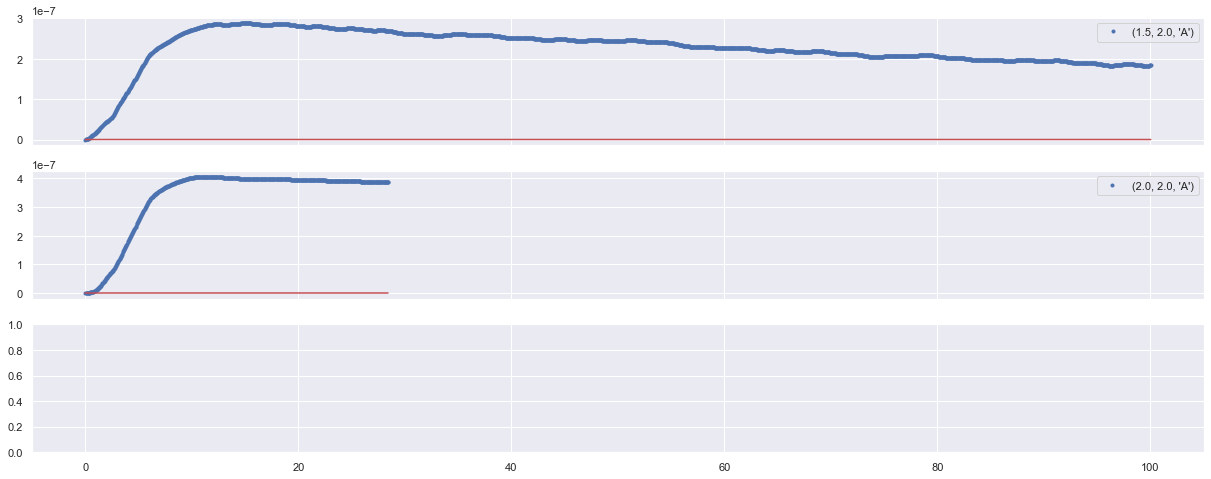

In [239]:
fig, ax = plt.subplots(len(conc_list)+1, figsize = (21,len(conc_list)*4), sharex=True)
for i, exp in enumerate(conc_list):
    ax[i].plot(experiments[exp].HNO[ini_point:fin_point].index.total_seconds().values, experiments[exp].HNO[ini_point:fin_point].values, 'b.', label = str(exp))
    ax[i].plot(experiments[exp].HNO[ini_point:fin_point].index.total_seconds().values, hno_t(experiments[exp].HNO[ini_point:fin_point].index.total_seconds().values, k_vals, y0_vec[i]),'r')
    ax[i].legend()

In [113]:
max_HNO = []
NO_0 =[]
H2S_0 = []
for exp in experiments.keys():
    max_HNO.append(experiments[exp].HNO.max())
    NO_0.append(exp[0])
    H2S_0.append(exp[1])   
data = pd.DataFrame({'NO_0':NO_0, 'H2S_0':H2S_0, 'HNOmax':max_HNO})

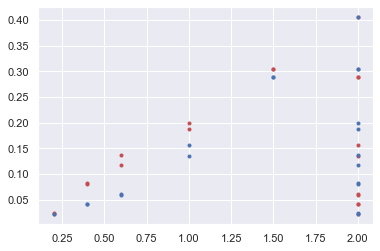

In [13]:
plt.plot(data.H2S_0, data.HNOmax,'r.')
plt.plot(data.NO_0, data.HNOmax,'b.')
plt.show()

In [14]:
experiments.keys()

dict_keys([(0.6, 2.0, 'A'), (2.0, 1.0, 'B'), (0.4, 2.0, 'A'), (2.0, 0.2, 'B'), (0.2, 2.0, 'A'), (2.0, 1.5, 'A'), (2.0, 1.5, 'B'), (1.0, 2.0, 'B'), (1.0, 2.0, 'A'), (2.0, 2.0, 'A'), (2.0, 0.6, 'B'), (0.6, 2.0, 'B'), (1.5, 2.0, 'A'), (1.5, 2.0, 'B'), (2.0, 0.2, 'A'), (0.4, 2.0, 'B'), (2.0, 0.6, 'A'), (2.0, 1.0, 'A'), (2.0, 0.4, 'A'), (2.0, 0.4, 'B')])

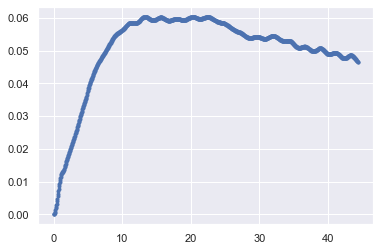

In [15]:
plt.plot(experiments[(0.6, 2.0, 'A')].HNO.index.total_seconds(),experiments[(0.6, 2.0, 'A')].HNO,'.')
plt.show()

In [16]:
def initial_rate(experiment, ini, fin):
    x = experiment.HNO.index.total_seconds()
    y = experiment.HNO.values
    
    x_fit = x[ini:fin]
    y_fit = y[ini:fin]
    
    slope, intercept, r_value, p_value, std_err = linregress(x_fit,y_fit)
    
    plt.plot(x, y, '.', alpha = 0.1)
    plt.plot(x_fit, x_fit*slope + intercept, 'k-')
    
    return slope

In [17]:
n_exp = list(experiments.keys())

0.06558188552766549

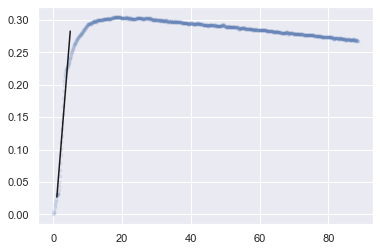

In [18]:
initial_rate(experiments[n_exp[5]],10,50)

In [19]:
data['slopes'] = [0.0085, 0.0387, 0.0073, 0.0053, 0.0048, 0.0656, 0.0728, 0.0181, 0.0165, 0.0673, 0.0313, 0.0114, 0.0335, 0.0316, 0.00576, 0.00533, 0.03412, 0.041, 0.0324, 0.0249]

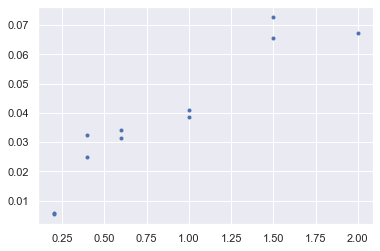

In [20]:
plt.plot(data[data.NO_0 == 2.0].H2S_0,data[data.NO_0 == 2.0].slopes,'.')
plt.show()


In [21]:
data[data.NO_0 == 2.0]

,NO_0,H2S_0,HNOmax,slopes
1,2.0,1.0,0.199400,0.03870
3,2.0,0.2,0.022530,0.00530
5,2.0,1.5,0.304665,0.06560
6,2.0,1.5,0.305100,0.07280
9,2.0,2.0,0.406045,0.06730
10,2.0,0.6,0.117486,0.03130
14,2.0,0.2,0.023600,0.00576
16,2.0,0.6,0.136733,0.03412
17,2.0,1.0,0.186812,0.04100
18,2.0,0.4,0.081680,0.03240


In [79]:
np.linspace(0,40,41)[0::10]

array([ 0., 10., 20., 30., 40.])

In [119]:
sorted(list(experiments.keys()))

[(0.2, 2.0, 'A'),
 (0.4, 2.0, 'A'),
 (0.4, 2.0, 'B'),
 (0.6, 2.0, 'A'),
 (0.6, 2.0, 'B'),
 (1.0, 2.0, 'A'),
 (1.0, 2.0, 'B'),
 (1.5, 2.0, 'A'),
 (1.5, 2.0, 'B'),
 (2.0, 0.2, 'A'),
 (2.0, 0.2, 'B'),
 (2.0, 0.4, 'A'),
 (2.0, 0.4, 'B'),
 (2.0, 0.6, 'A'),
 (2.0, 0.6, 'B'),
 (2.0, 1.0, 'A'),
 (2.0, 1.0, 'B'),
 (2.0, 1.5, 'A'),
 (2.0, 1.5, 'B'),
 (2.0, 2.0, 'A')]

In [205]:
leastsq?